**Mounting Drive![image_2023-12-10_234250390.png](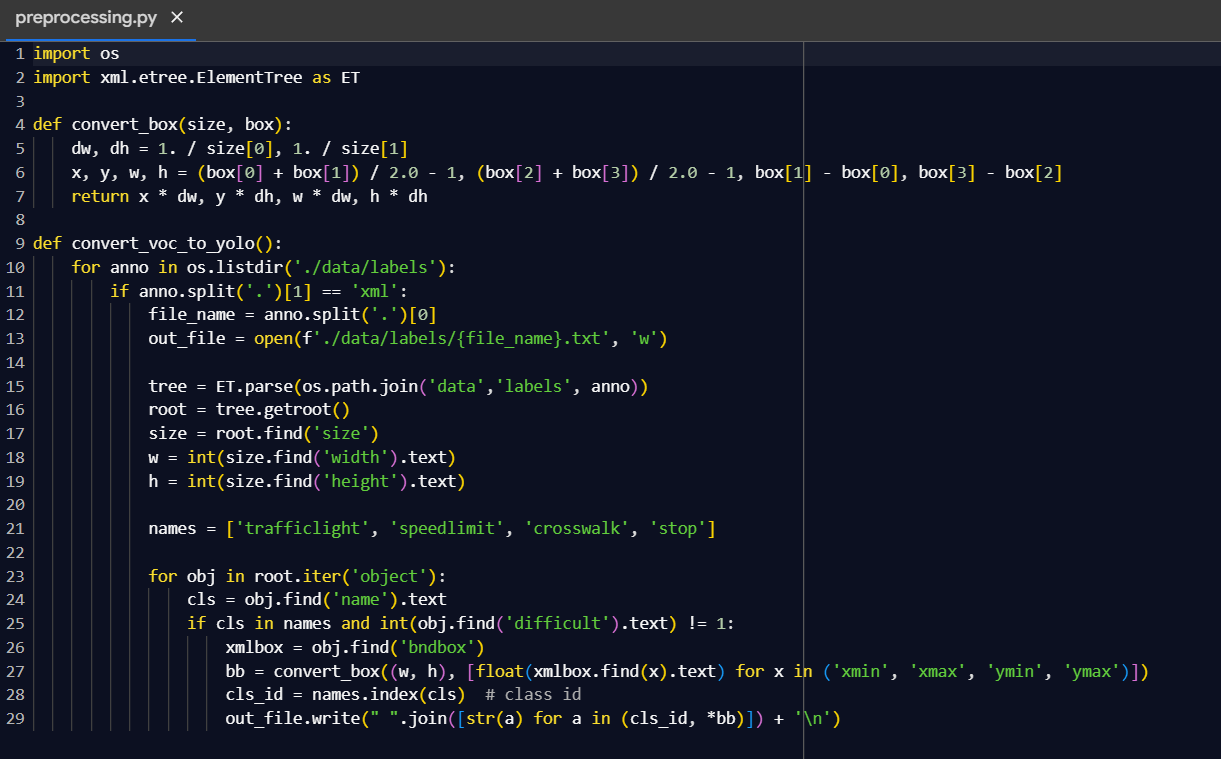![image_2023-12-10_234310575.png](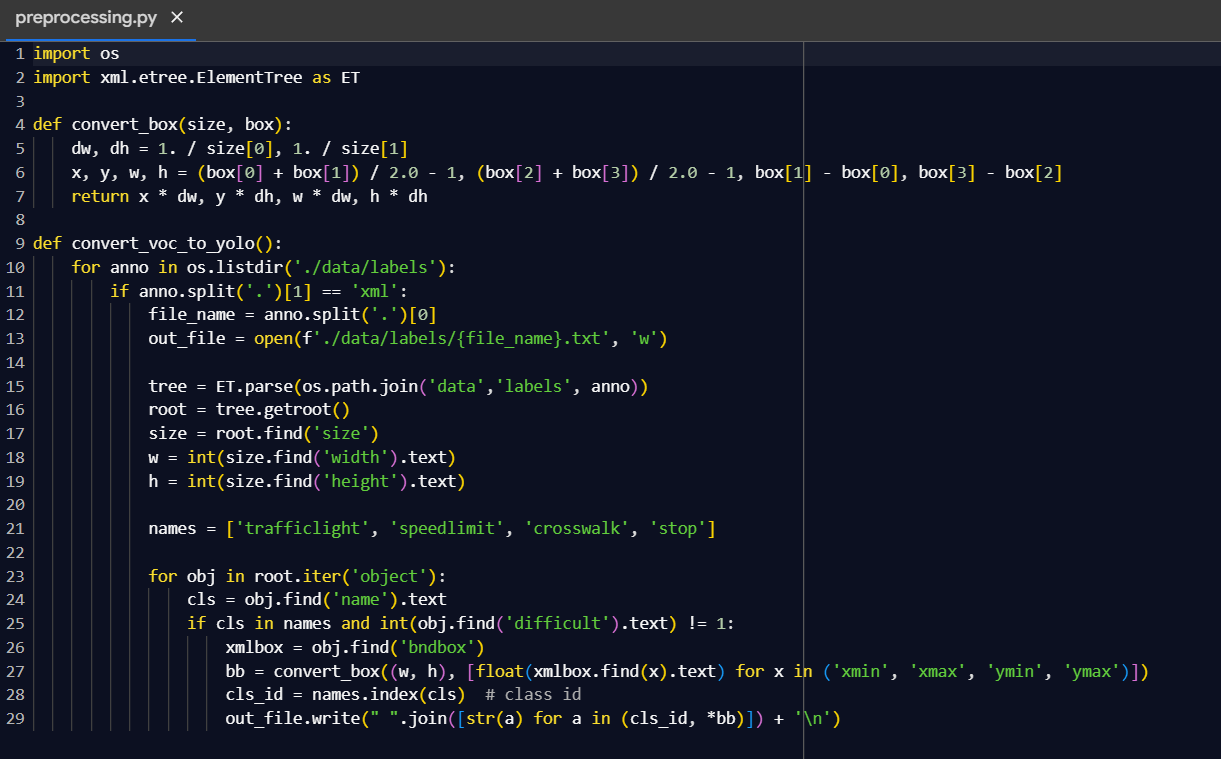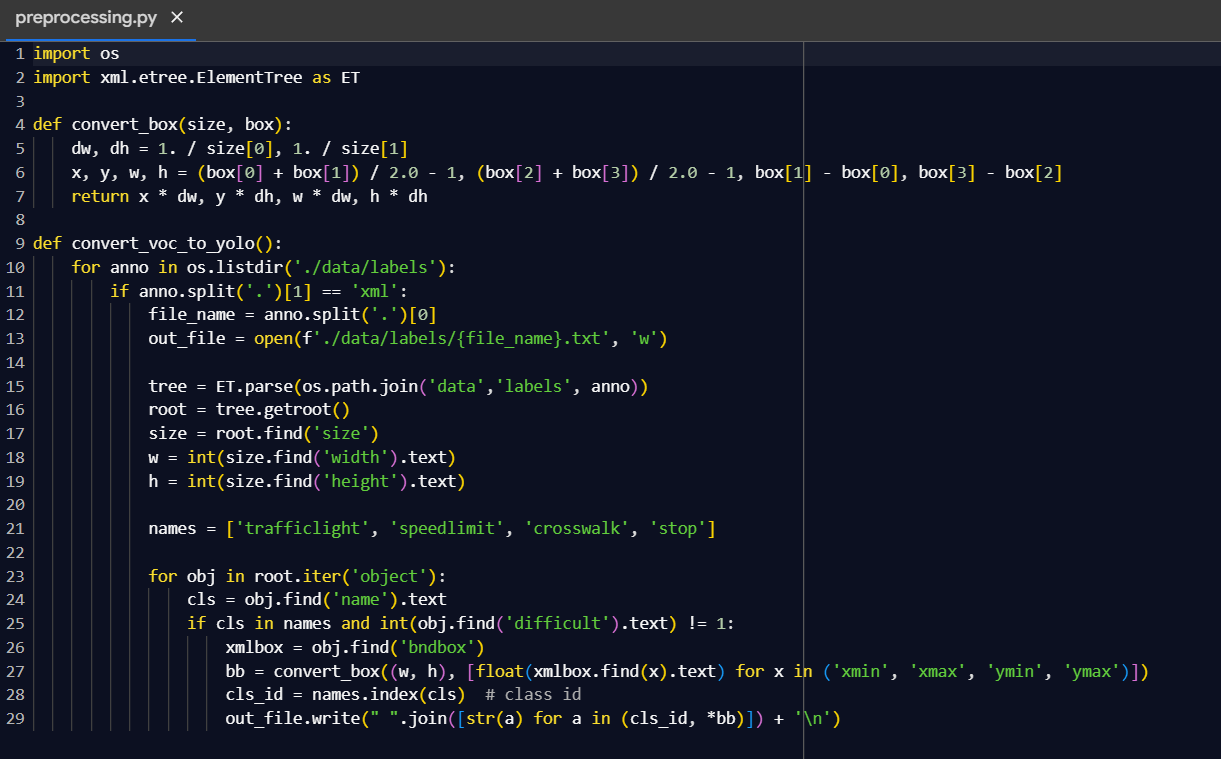))**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Setting Up Kaggle tp Download Database**

In [2]:
#Uploading the kaggle.json to access Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"feresbaba","key":"630d5d670ae916c25ae939c4c80aa791"}'}

In [7]:
! mkdir ~/.kaggle/
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download -d andrewmvd/road-sign-detection

 92% 200M/218M [00:01<00:00, 208MB/s]
100% 218M/218M [00:01<00:00, 139MB/s]


In [10]:
! unzip road-sign-detection.zip -d data

Archive:  road-sign-detection.zip
  inflating: data/annotations/road0.xml  
  inflating: data/annotations/road1.xml  
  inflating: data/annotations/road10.xml  
  inflating: data/annotations/road100.xml  
  inflating: data/annotations/road101.xml  
  inflating: data/annotations/road102.xml  
  inflating: data/annotations/road103.xml  
  inflating: data/annotations/road104.xml  
  inflating: data/annotations/road105.xml  
  inflating: data/annotations/road106.xml  
  inflating: data/annotations/road107.xml  
  inflating: data/annotations/road108.xml  
  inflating: data/annotations/road109.xml  
  inflating: data/annotations/road11.xml  
  inflating: data/annotations/road110.xml  
  inflating: data/annotations/road111.xml  
  inflating: data/annotations/road112.xml  
  inflating: data/annotations/road113.xml  
  inflating: data/annotations/road114.xml  
  inflating: data/annotations/road115.xml  
  inflating: data/annotations/road116.xml  
  inflating: data/annotations/road117.xml  
  in

**Simple Preprocessing File to convert from VOC XML to YOLO Annotation**

In [12]:
#Using a preprocessing file to convert VOC XML annotation files to .txt Yolo type
!cp /content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/preprocessing.py /content/
from preprocessing import convert_voc_to_yolo
!mv /content/data/annotations /content/data/labels
convert_voc_to_yolo()

**Preparing For Data Splitting (80% Training / 20% Validation)**

In [13]:
train_path_img = "/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/yolo_data/images/train/"
train_path_label = "/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/yolo_data/labels/train/"
val_path_img = "/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/yolo_data/images/val/"
val_path_label = "/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/yolo_data/labels/val/"
test_path = "/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/yolo_data/test"

In [14]:
import os
import shutil
import random

!pip install tqdm --upgrade
from tqdm.notebook import tqdm

In [15]:
!mv /content/data/images/* /content/data/
!mv /content/data/labels/* /content/data/
!rm -r /content/data/images/
!rm -r /content/data/labels/

In [16]:
def train_test_split(path,neg_path=None, split = 0.2):
    print("------ PROCESS STARTED -------")


    files = list(set([name[:-4] for name in os.listdir(path)])) ## removing duplicate names i.e. counting only number of images


    print (f"--- This folder has a total number of {len(files)} images---")
    random.seed(42)
    random.shuffle(files)

    #split
    test_size = int(len(files) * split)
    train_size = len(files) - test_size


    #directories
    os.makedirs(train_path_img, exist_ok = True)
    os.makedirs(train_path_label, exist_ok = True)
    os.makedirs(val_path_img, exist_ok = True)
    os.makedirs(val_path_label, exist_ok = True)


    #Training Section
    for filex in tqdm(files[:train_size]):
      if (filex == 'classes' or filex =='.ipynb_checkpo'):
          continue
      shutil.copy2(path + filex + '.png',f"{train_path_img}/" + filex + '.png' )
      shutil.copy2(path + filex + '.txt', f"{train_path_label}/" + filex + '.txt')



    print(f"------ Training data created with 80% split {len(files[:train_size])} images -------")

    if neg_path:
        neg_images = list(set([name[:-4] for name in os.listdir(neg_path)])) ## removing duplicate names i.e. counting only number of images
        for filex in tqdm(neg_images):
            shutil.copy2(neg_path+filex+ ".png", f"{train_path_img}/" + filex + '.png')

        print(f"------ Total  {len(neg_images)} negative images added to the training data -------")

        print(f"------ TOTAL Training data created with {len(files[:train_size]) + len(neg_images)} images -------")



    ### copytin images to validation folder
    for filex in tqdm(files[train_size:]):
      if filex == 'classes':
          continue
      # print("running")
      shutil.copy2(path + filex + '.png', f"{val_path_img}/" + filex + '.png' )
      shutil.copy2(path + filex + '.txt', f"{val_path_label}/" + filex + '.txt')

    print(f"------ Testing data created with a total of {len(files[train_size:])} images ----------")

    print("------ TASK COMPLETED -------")

## spliting the data into train-test and creating train.txt and test.txt files
# train_test_split('/content/drive/MyDrive/custom_notebooks/yolo_data/')

### for label_tag
train_test_split('/content/data/') ### without negative images
# train_test_split('./data/','./negative_images/') ### if you want to feed negative images

------ PROCESS STARTED -------
--- This folder has a total number of 877 images---


  0%|          | 0/702 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

**Setting Up YOLOv8**

In [3]:
!pip install ultralytics

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.226 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.9/78.2 GB disk)


**Training YOLOv8 on Different Parameters For Better Precision**

In [18]:
!yolo task=detect mode=train model=yolov8s.pt data=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/dataset.yaml epochs=10 imgsz=320 batch=16 project=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/training_results name=Road-Sign-Detection


100% 21.5M/21.5M [00:00<00:00, 199MB/s]
New https://pypi.org/project/ultralytics/8.0.226 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/dataset.yaml, epochs=10, patience=50, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/training_results, name=Road-Sign-Detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, str

In [19]:
!yolo task=detect mode=train model=yolov8s.pt data=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/dataset.yaml epochs=20 imgsz=320 batch=16 project=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/training_results name=Road-Sign-Detection

New https://pypi.org/project/ultralytics/8.0.226 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/dataset.yaml, epochs=20, patience=50, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/training_results, name=Road-Sign-Detection2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augm

In [20]:
!yolo task=detect mode=train model=yolov8s.pt data=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/dataset.yaml epochs=30 imgsz=320 batch=16 project=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/training_results name=Road-Sign-Detection

New https://pypi.org/project/ultralytics/8.0.226 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/dataset.yaml, epochs=30, patience=50, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/training_results, name=Road-Sign-Detection3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augm

In [22]:
!yolo task=detect mode=train model=yolov8s.pt data=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/dataset.yaml epochs=20 imgsz=320 batch=4 project=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/training_results name=Road-Sign-Detection


New https://pypi.org/project/ultralytics/8.0.226 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/dataset.yaml, epochs=20, patience=50, batch=4, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/training_results, name=Road-Sign-Detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augmen

In [23]:
!yolo task=detect mode=train model=yolov8s.pt data=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/dataset.yaml epochs=20 imgsz=320 batch=8 project=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/training_results name=Road-Sign-Detection


New https://pypi.org/project/ultralytics/8.0.226 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/dataset.yaml, epochs=20, patience=50, batch=8, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/training_results, name=Road-Sign-Detection2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augme

In [24]:
!yolo task=detect mode=train model=yolov8s.pt data=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/dataset.yaml epochs=40 imgsz=320 batch=16 lr0=0.0001 project=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/training_results name=Road-Sign-Detection

New https://pypi.org/project/ultralytics/8.0.226 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/dataset.yaml, epochs=40, patience=50, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/training_results, name=Road-Sign-Detection3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augm

**Testing The Model On A Random Uploaded Image**

In [10]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/Colab-Notebooks/Stop-Sign-YOLOv8/training_results/Road-Sign-Detection3/weights/best.pt")

source = '/content/images.png'

results = model(source)

for r in results:
  print(r.keypoints)


image 1/1 /content/images.png: 320x256 2 trafficlights, 29.9ms
Speed: 1.7ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 256)
None
